# Objetivos deste trabalho
- Familiarizar-se com a biblioteca PyTorch
- Definir arquiteturas MLP simples em PyTorch
- Treinar utilizando CIFAR10, testando diferentes arquiteturas, parâmetros, funções de loss e otimizadores
- Comparar os resultados obtidos utilizando apenas Perpceptrons

In [0]:
# importando bibliotecas necessárias

%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

In [2]:
# carregar os datasets

# utilizando imagens em tons de cinza
transform=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

# criando dataset de validação a partir do dataset de treino
# como dataset é suficientemente grande, amostras aleatórias são representativas (não exige extratificação)
dataset_validation, dataset_train = torch.utils.data.random_split(dataset_train, [5000, 45000])

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# configurando dataset loaders

train_loader = DataLoader(dataset=dataset_train, shuffle=True, batch_size=256)
validation_loader = DataLoader(dataset=dataset_validation, shuffle=False, batch_size=256)
test_loader = DataLoader(dataset=dataset_test, shuffle=False, batch_size=256)


In [0]:
# definindo a arquitetura MLP

# utilizando camada de entrada 32x32 e camada de saída 10
# arquitetura da rede: 1024 x 100 x 50 x 30 x 10 (três camadas ocultas)
# utilizando ReLU como função de ativação

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 30)
        self.fc4 = nn.Linear(30, 10)

        self.activation_function = nn.ReLU()
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = self.activation_function(self.fc1(x))
        x = self.activation_function(self.fc2(x))
        x = self.activation_function(self.fc3(x))
        x = self.activation_function(self.fc4(x))
        return x
    

In [5]:
# instanciando o modelo

model = MLP()
model.cuda()
print(model)

MLP(
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=30, bias=True)
  (fc4): Linear(in_features=30, out_features=10, bias=True)
  (activation_function): ReLU()
)


In [0]:
# definindo otimizador e loss

optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
loss_fn = nn.CrossEntropyLoss()

# outros otimizadores
#loss_fn = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [7]:
# realizando o treinamento

epochs = 100
train_losses = []
running_losses_list = []
train_accuracy_list = []
#alpha = 0.001

# caso utilizando onehot
# to_onehot = torch.eye(10)

for epoch in range(epochs):
    model.train()
    i = 0
    running_loss = 0.0
    accuracy = 0.0
    total = 0
    correct = 0
    
    
    for images, labels in train_loader:
        images = images.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        # caso utilizando onehot
        # one_hot_labels = to_onehot[labels].cuda()
        
        # utilizando regularizador L2
        #regularization_loss = 0
        #for param in model.parameters():
        #    regularization_loss += torch.sum(torch.abs(param))
            
        loss = loss_fn(outputs, labels) #+ alpha * regularization_loss
        
        loss.backward()
        optimizer.step()
        
        i += 1
        
        train_losses.append(loss.item())
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    accuracy = correct / total
    train_accuracy_list.append(accuracy)
        
        
    running_losses_list.append(running_loss)
    print("Epoch: %5d \t Loss: %.5f \t Accuracy: %.5f" %(epoch+1, running_loss, accuracy))

Epoch:     1 	 Loss: 403.33114 	 Accuracy: 0.14091
Epoch:     2 	 Loss: 387.98918 	 Accuracy: 0.19020
Epoch:     3 	 Loss: 373.94256 	 Accuracy: 0.23800
Epoch:     4 	 Loss: 367.41417 	 Accuracy: 0.25720
Epoch:     5 	 Loss: 362.63340 	 Accuracy: 0.27420
Epoch:     6 	 Loss: 357.55544 	 Accuracy: 0.28942
Epoch:     7 	 Loss: 352.23118 	 Accuracy: 0.29956
Epoch:     8 	 Loss: 348.85278 	 Accuracy: 0.30593
Epoch:     9 	 Loss: 341.64161 	 Accuracy: 0.32036
Epoch:    10 	 Loss: 332.12394 	 Accuracy: 0.32689
Epoch:    11 	 Loss: 326.78642 	 Accuracy: 0.33656
Epoch:    12 	 Loss: 321.78187 	 Accuracy: 0.34704
Epoch:    13 	 Loss: 317.97703 	 Accuracy: 0.35320
Epoch:    14 	 Loss: 314.66692 	 Accuracy: 0.36156
Epoch:    15 	 Loss: 311.60400 	 Accuracy: 0.36680
Epoch:    16 	 Loss: 307.79097 	 Accuracy: 0.37747
Epoch:    17 	 Loss: 305.04780 	 Accuracy: 0.38491
Epoch:    18 	 Loss: 303.39721 	 Accuracy: 0.38818
Epoch:    19 	 Loss: 298.79135 	 Accuracy: 0.39504
Epoch:    20 	 Loss: 297.23331 

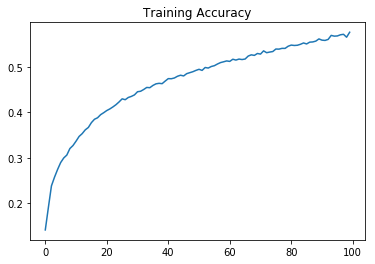

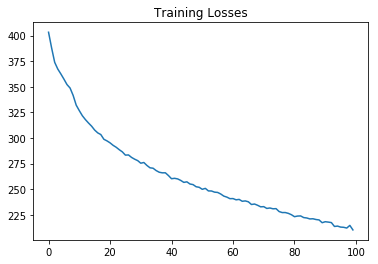

In [8]:
# plot dos resultados
plt.plot(train_accuracy_list, label='')
plt.title("Training Accuracy")
plt.show()

plt.plot(running_losses_list, label='')
plt.title("Training Losses")
plt.show()


In [9]:
# avaliando o modelo aqui (no conjunto de validação) (ou teste, caso entrega)

test_losses = []
test_accuracies = []

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader: #validation_loader
        images = images.cuda()
        labels = labels.cuda()
        
        outputs = model(images)
        
        #one_hot_labels = to_onehot[labels].cuda()
        
        #regularization_loss = 0
        #for param in model.parameters():
        #    regularization_loss += torch.sum(torch.abs(param))
            
        loss = loss_fn(outputs, labels)# + alpha * regularization_loss

        test_losses.append(loss.item())
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        
accuracy = correct / total

#test_accuracies.append(accuracy)
print('Epochs: {} \t Train Loss: {:.4f} \t Test Loss: {:.4f} \t Test Accuracy: {:.2f}'\
     .format(epoch+1, np.mean(train_losses), np.mean(test_losses), accuracy))

Epochs: 100 	 Train Loss: 1.4968 	 Test Loss: 1.7159 	 Test Accuracy: 0.44


In [10]:
# print da acurácia individual de cada classe

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for images, labels in test_loader: #validation_loader
        images = images.cuda()
        labels = labels.cuda()
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 18 %
Accuracy of   car : 61 %
Accuracy of  bird : 38 %
Accuracy of   cat : 22 %
Accuracy of  deer :  0 %
Accuracy of   dog : 46 %
Accuracy of  frog : 44 %
Accuracy of horse : 50 %
Accuracy of  ship : 66 %
Accuracy of truck : 47 %


Alguns resultados utilizando conjunto de validação:


---


#Utilizando a arquitetura:

MLP(

    (fc1): Linear(in_features=1024, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=50, bias=True)
    (fc3): Linear(in_features=50, out_features=30, bias=True)
    (fc4): Linear(in_features=30, out_features=10, bias=True)
    (activation_function): ReLU()
 )

#Parâmetros:

1.   learningRate = 0.01, optimizer = SGD, lossFn = MSE, batchSize = 256

2.   learningRate = 0.001, optimizer = Adam, lossFn = CrossEntropy, batchSize = 32

3.   learningRate = 0.001, optimizer = Adam, lossFn = CrossEntropy, batchSize = 256

4.   learningRate = 0.01, optimizer = Adam, lossFn = CrossEntropy, batchSize = 256

#Resultados:

1.   Epochs: 100 	 Train Loss: 0.0911 	 Validation Loss: 0.0883 	 Validation Accuracy: 0.23

2.   Epochs: 100 	 Train Loss: 1.8516 	 Validation Loss: 2.0312 	 Validation Accuracy: 0.32

3.   Epochs: 100 	 Train Loss: 1.6239 	 Validation Loss: 1.7859 	 Validation Accuracy: 0.40

4.   Epochs: 100 	 Train Loss: 2.0603 	 Validation Loss: 2.1012 	 Validation Accuracy: 0.26

---


#Utilizando a arquitetura:

MLP(

    (fc1): Linear(in_features=1024, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=50, bias=True)
    (fc3): Linear(in_features=50, out_features=30, bias=True)
    (fc4): Linear(in_features=30, out_features=10, bias=True)
    (activation_function): Sigmoid()
 )

#Parâmetros:

1.  learningRate = 0.001, optimizer = Adam, lossFn = CrossEntropy, batchSize = 256

2.  learningRate = 0.001, momentum = 0.9, optimizer = SGD, lossFn = CrossEntropy, batchSize = 256

#Resultados:

1.  Epochs: 100 	 Train Loss: 2.0061 	 Validation Loss: 1.9997 	 Validation Accuracy: 0.32

2.  Epochs: 100 	 Train Loss: 1.7223 	 Validation Loss: 1.7345 	 Validation Accuracy: 0.42

---


#Utilizando a arquitetura:

MLP(

    (fc1): Linear(in_features=1024, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=150, bias=True)
    (fc3): Linear(in_features=150, out_features=100, bias=True)
    (fc4): Linear(in_features=100, out_features=80, bias=True)
    (fc5): Linear(in_features=80, out_features=50, bias=True)
    (fc6): Linear(in_features=50, out_features=30, bias=True)
    (fc7): Linear(in_features=30, out_features=10, bias=True)
    (activation_function): ReLU()
)

#Parâmetros:

1.   learningRate = 0.001, optimizer = Adam, lossFn = CrossEntropy, batchSize = 256

#Resultados:

1.   Epochs: 100 	 Train Loss: 1.6909 	 Validation Loss: 2.4314 	 Validation Accuracy: 0.33

---


#Utilizando a arquitetura:

MLP(

    (fc1): Linear(in_features=1024, out_features=30, bias=True)
    (fc2): Linear(in_features=30, out_features=20, bias=True)
    (fc3): Linear(in_features=20, out_features=10, bias=True)
    (activation_function): ReLU()
)

#Parâmetros:

1.  learningRate = 0.001, optimizer = Adam, lossFn = CrossEntropy, batchSize = 256

#Resultados:

1.  Epochs: 100 	 Train Loss: 1.8636 	 Validation Loss: 1.8863 	 Validation Accuracy: 0.35



---
# Resultados Finais
# Utilizando a arquitetura:

MLP(

    (fc1): Linear(in_features=1024, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=50, bias=True)
    (fc3): Linear(in_features=50, out_features=30, bias=True)
    (fc4): Linear(in_features=30, out_features=10, bias=True)
    (activation_function): Sigmoid()
 )
 
#Parâmetros:

1.  learningRate = 0.01, momentum = 0.9, optimizer = SGD, lossFn = CrossEntropy, batchSize = 256

#Resultados:

1.  Epochs: 100 	 Train Loss: 1.4968 	 Test Loss: 1.7159 	 Test Accuracy: 0.44
 